<a href="https://colab.research.google.com/github/cifcs2/Sentiment-Analysis-of-Former-Presidents-SONA-using-NLP/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("datacleanlabel.csv")

In [4]:
# set label values based on sentiment_label column
df.loc[df["sentiment_label"] == "POSITIVE", "label"] = 1
df.loc[df["sentiment_label"] == "NEGATIVE", "label"] = 0

# save the updated DataFrame to a new csv file
df.to_csv("datacleanlabelforplot.csv", index=False)

In [5]:
df.head

<bound method NDFrame.head of      president_year                                           sentence  label  \
0      Estrada-1998   state nation address excellency joseph ejerci...    1.0   
1      Estrada-1998               kagalanggalang na pangulo ng senado.    0.0   
2      Estrada-1998  kagalanggalang na speaker ng mababang kapulungan.    0.0   
3      Estrada-1998   kagalanggalang na punong hukom ng korte suprema.    0.0   
4      Estrada-1998  kagalanggalang na mga miyembro ng kongreso ng ...    1.0   
...             ...                                                ...    ...   
9090   Duterte-2021         puno ang pila nito pagdating sa cr mamaya.    0.0   
9091   Duterte-2021  full confidence filipino spirit persevere triu...    1.0   
9092   Duterte-2021                      together, let us rise nation.    1.0   
9093   Duterte-2021                                         thank you.    1.0   
9094   Duterte-2021                                            — end —    0.0  

In [6]:
df.shape

(9095, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9095 entries, 0 to 9094
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   president_year   9095 non-null   object 
 1   sentence         9095 non-null   object 
 2   label            9095 non-null   float64
 3   sentiment_label  9095 non-null   object 
 4   sentiment_score  9095 non-null   float64
dtypes: float64(2), object(3)
memory usage: 355.4+ KB


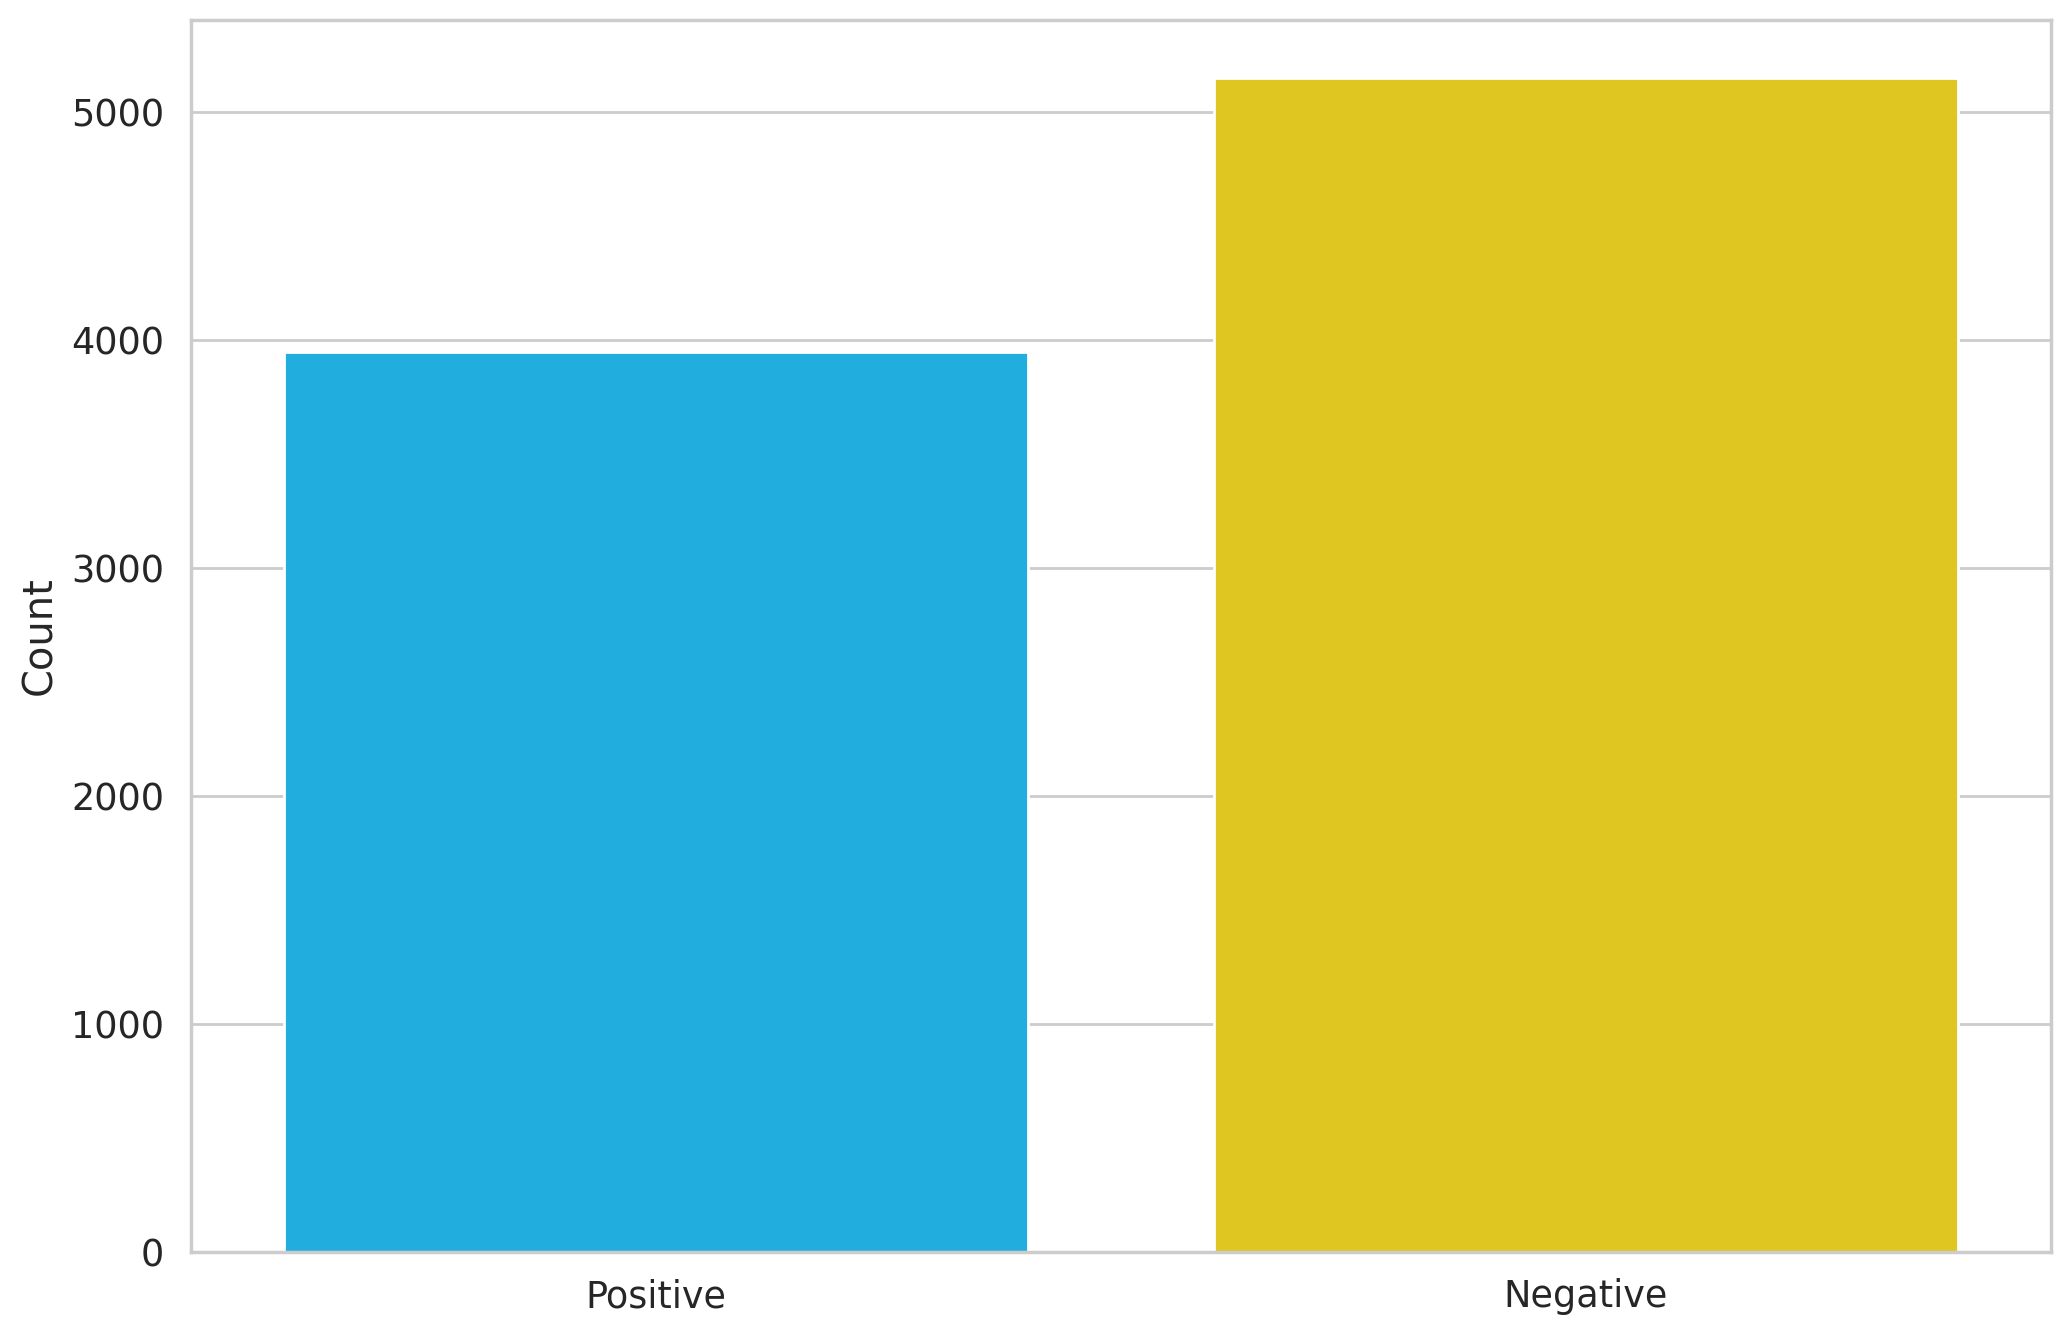

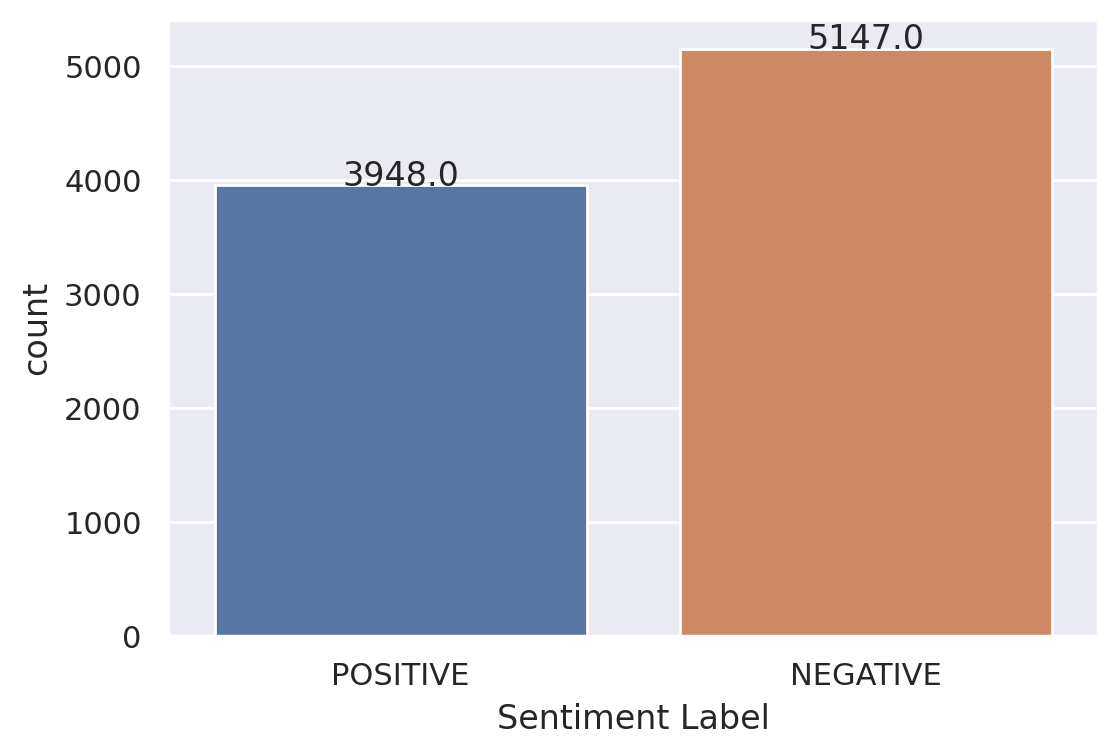

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# subset the dataframe for positive, negative, and neutral labels
pos_df = df[df['label'] == 1]
neg_df = df[df['label'] == 0]

# count the number of sentences in each subset
pos_count = len(pos_df)
neg_count = len(neg_df)

# plot the counts as a bar plot
sns.barplot(x=['Positive', 'Negative'], y=[pos_count, neg_count])
plt.ylabel('Count')

# assuming df is your DataFrame with sentiment labels
sns.set(style='darkgrid')
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='sentiment_label', data=df)
plt.xlabel('Sentiment Label')

# add count values to the bars
for p in ax.patches:
    count = p.get_height()
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y, count, ha='center', fontsize=12)
plt.show()


In [9]:
##BERT

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [13]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [14]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [18]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [19]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [20]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [21]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [22]:
token_lens = []
for txt in df.sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-23-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


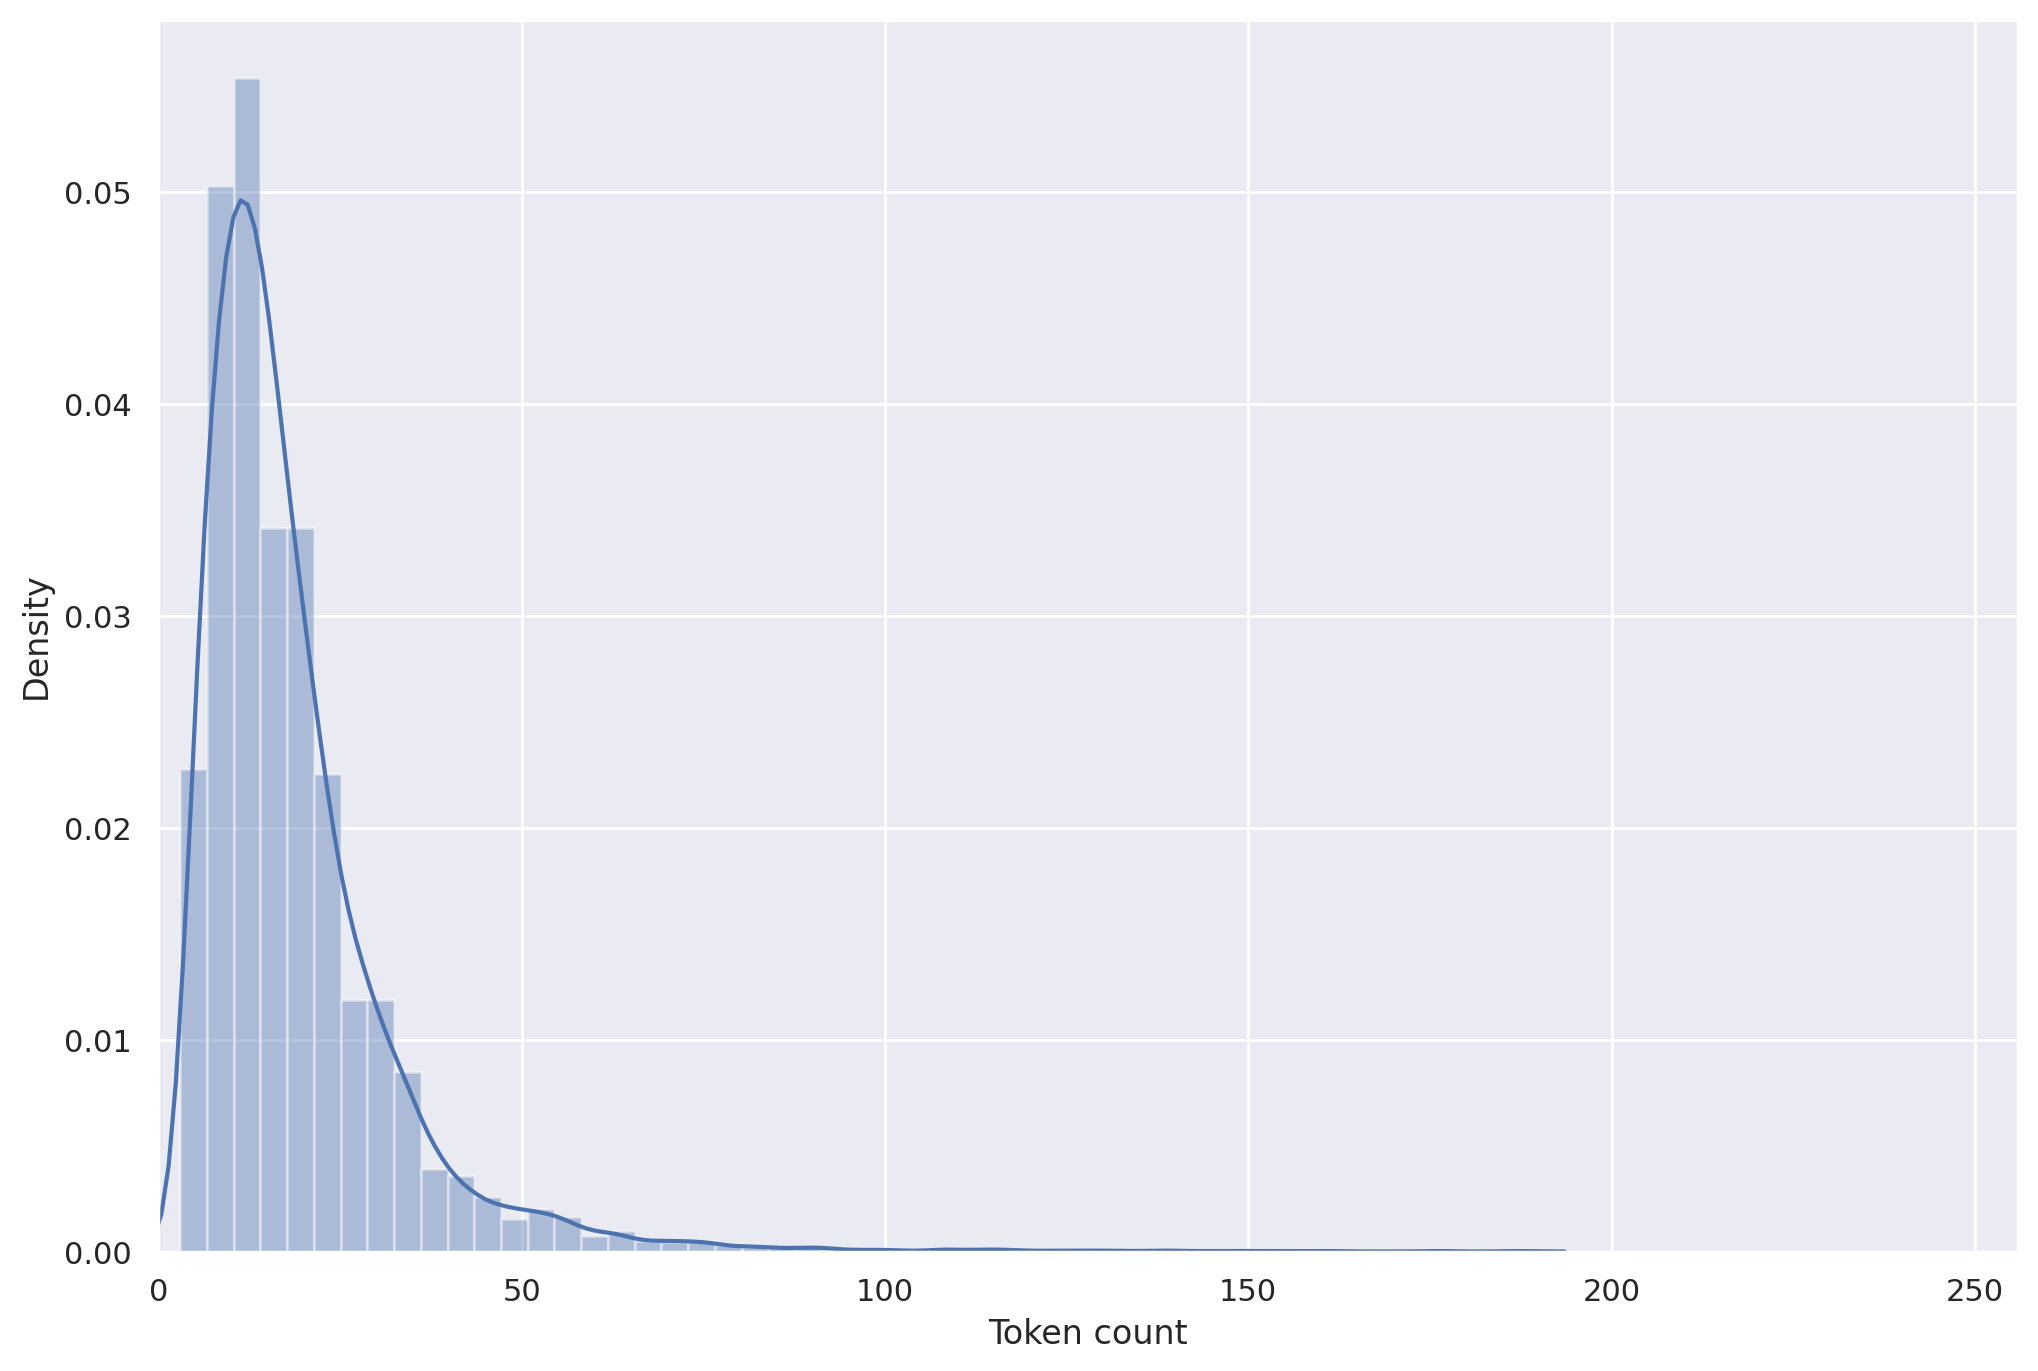

In [23]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [24]:
MAX_LEN = 160

In [25]:
class SONADataset(Dataset):
    def __init__(self, sentence, label, tokenizer, max_len):
        self.sentence = sentence
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentence)
        
    def __getitem__(self, item):
        sentence = str(self.sentence[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
        }


In [26]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [27]:
df_train.shape, df_val.shape, df_test.shape

((8185, 5), (455, 5), (455, 5))

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SONADataset(
    sentence=df.sentence.to_numpy(),
    label=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


In [29]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['sentence', 'input_ids', 'attention_mask', 'label'])

In [31]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


BERT part2

In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [34]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)
    
    model = SentimentClassifier(3)

In [35]:
input_ids = torch.tensor(encoding['input_ids']).to(device)
attention_mask = torch.tensor(encoding['attention_mask']).to(device)


<ipython-input-35-9cc29b5ec0ba>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids']).to(device)
<ipython-input-35-9cc29b5ec0ba>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoding['attention_mask']).to(device)


In [36]:
model = SentimentClassifier(len(df_train.label.unique()))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [38]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3028, 0.6972],
        [0.4749, 0.5251],
        [0.5661, 0.4339],
        [0.3351, 0.6649],
        [0.7676, 0.2324],
        [0.3987, 0.6013],
        [0.4479, 0.5521],
        [0.6665, 0.3335],
        [0.6728, 0.3272],
        [0.6718, 0.3282],
        [0.6476, 0.3524],
        [0.6616, 0.3384],
        [0.3658, 0.6342],
        [0.4723, 0.5277],
        [0.5831, 0.4169],
        [0.2788, 0.7212]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [39]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    label = d["label"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, label)
    correct_predictions += torch.sum(preds == label)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
print(df_val['label'].unique())


[0. 1.]


In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.450130400568014 accuracy 0.7931582162492364
Val   loss 0.3054262836431635 accuracy 0.8637362637362638

Epoch 2/10
----------


KeyboardInterrupt: ignored